In [49]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

Import Tabular training data

In [50]:
df = pd.read_csv(r'C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\combined_features.csv')

Prepare data for modeling

In [51]:
df_wlabs = df.drop(columns=['ID'])

In [52]:
X = df_wlabs.drop(['height_above'], axis=1).select_dtypes(include=[np.number]).values
y = df_wlabs['height_above'].values

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


Final feature matrix shape: (1147, 61)
Target variable shape: (1147,)


In [53]:
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [54]:
# First split: 70% train, 30% temp (which will be split into 15% val + 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=54)

# Second split: Split the 30% temp into 15% val and 15% test (50-50 split of the temp data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=54)

print('Number of training observations:', y_train.shape[0], f'({y_train.shape[0]/len(y)*100:.1f}%)')
print('Number of validation observations:', y_val.shape[0], f'({y_val.shape[0]/len(y)*100:.1f}%)')
print('Number of test observations:', y_test.shape[0], f'({y_test.shape[0]/len(y)*100:.1f}%)')

Number of training observations: 802 (69.9%)
Number of validation observations: 172 (15.0%)
Number of test observations: 173 (15.1%)


In [55]:
# Z-score standardization based on training set statistics (prevents data leakage)
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

# Apply z-score standardization: (X - mean) / std
X_train_norm = (X_train - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

print('Training set standardized - shape:', X_train_norm.shape)
print('Validation set standardized - shape:', X_val_norm.shape)
print('Test set standardized - shape:', X_test_norm.shape)
print('\nTraining set statistics used for standardization:')
print('Mean:', X_mean)
print('Std:', X_std)
print('\nAfter z-score standardization:')
print('Training set - Mean: {:.6f}, Std: {:.6f}'.format(X_train_norm.mean(), X_train_norm.std()))
print('Validation set - Mean: {:.6f}, Std: {:.6f}'.format(X_val_norm.mean(), X_val_norm.std()))
print('Test set - Mean: {:.6f}, Std: {:.6f}'.format(X_test_norm.mean(), X_test_norm.std()))

Training set standardized - shape: (802, 61)
Validation set standardized - shape: (172, 61)
Test set standardized - shape: (173, 61)

Training set statistics used for standardization:
Mean: [ 2.66765407e+01  4.30021436e+01  3.26859378e+01  4.81388959e+00
  9.18090000e+00  9.82519439e+00  8.26581473e+00  9.02041272e-01
  7.58876185e-01  1.14948422e+01  7.20386961e+00  9.35356443e+00
  8.58741397e-01  1.65854652e+01  1.47079855e+00  1.35032544e-01
  2.15256693e+00  7.46442882e-01  6.85301746e-02  4.05730398e+00
  1.94449789e+01  1.78522406e+00  2.49809969e+01  2.79822452e+01
  2.56902195e+00  3.74982099e+01  1.39450521e+01 -2.76050309e+01
  6.78046064e+00 -1.05369148e+01  3.57699035e+00  3.03553940e+00
 -4.26110315e+01  7.02822060e-01 -1.84399926e+01  6.27217288e+00
  4.95218732e+00  1.74541892e+00  3.42558642e-01  6.18978803e+02
 -8.57993387e+01  3.15483321e+01  4.66194514e+01  3.02243973e+01
  4.21543697e-01  1.00863591e+03  3.38594763e+00  8.54617623e+01
  1.97654613e+01  0.00000000e+

Hyperparameter Tuning and Training of the RF Model

In [56]:
# Robust Hyperparameter Tuning with Cross-Validation
rf = RandomForestRegressor(random_state=54)

# Parameter grid for regression
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Cross-validation for regression
rf_cv = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=100,  # More iterations for better search
    cv=5,       # 10-fold CV for more robust evaluation
    scoring='neg_mean_squared_error',  # MSE for regression
    random_state=54,
    n_jobs=-1,   # Use all cores
    verbose=1
)

print("Starting hyperparameter optimization...")
rf_optimized = rf_cv.fit(X_train_norm, y_train)

print('Best parameters:', rf_optimized.best_params_)
print('Best cross-validation score (neg_MSE):', rf_optimized.best_score_)

Starting hyperparameter optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
Best cross-validation score (neg_MSE): -0.27501244026968696


In [60]:
# Model Evaluation on All Sets
best_rf = rf_optimized.best_estimator_

# Predictions on all sets
y_train_pred = best_rf.predict(X_train_norm)
y_val_pred = best_rf.predict(X_val_norm)
y_test_pred = best_rf.predict(X_test_norm)

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

def calculate_regression_metrics(y_true, y_pred, set_name):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Metrics:")
    print("-" * 30)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Calculate metrics for all sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_regression_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test")

MODEL PERFORMANCE METRICS

Training Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.0662
Root Mean Squared Error (RMSE): 0.2574
Mean Absolute Error (MAE): 0.1733
R² Score: 0.8611

Validation Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.4981
Root Mean Squared Error (RMSE): 0.7058
Mean Absolute Error (MAE): 0.4352
R² Score: 0.0920

Test Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.1887
Root Mean Squared Error (RMSE): 0.4344
Mean Absolute Error (MAE): 0.3126
R² Score: 0.5433


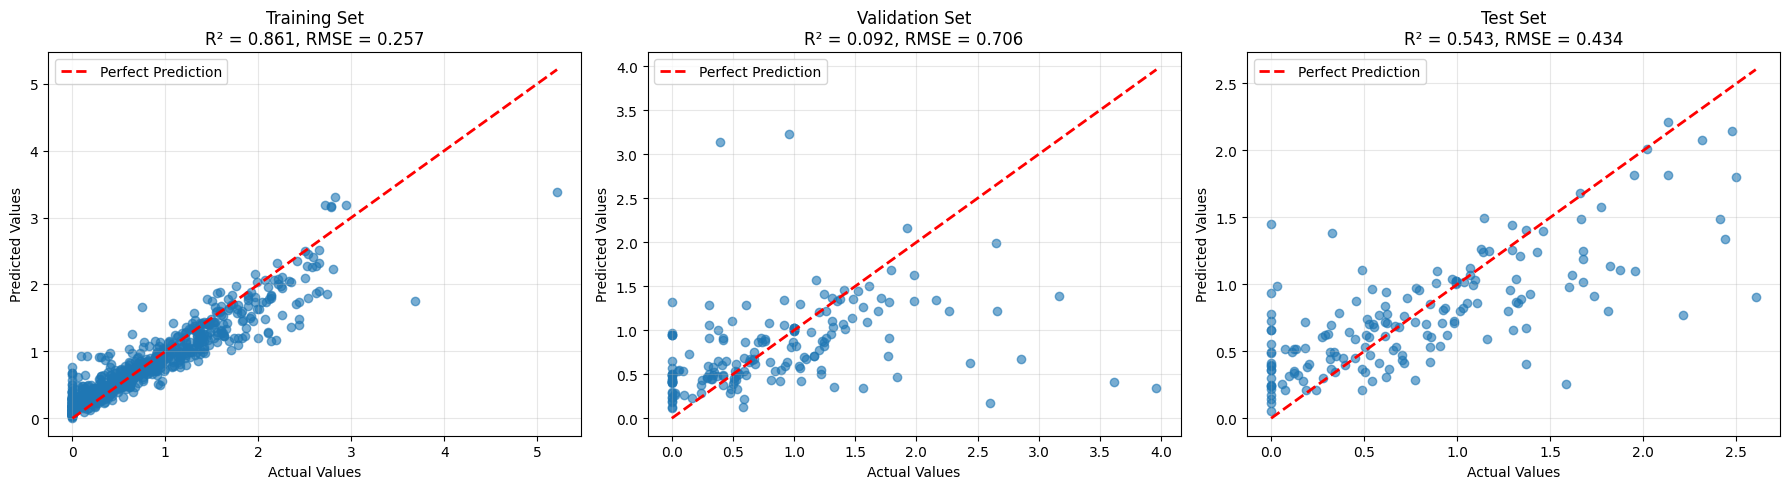

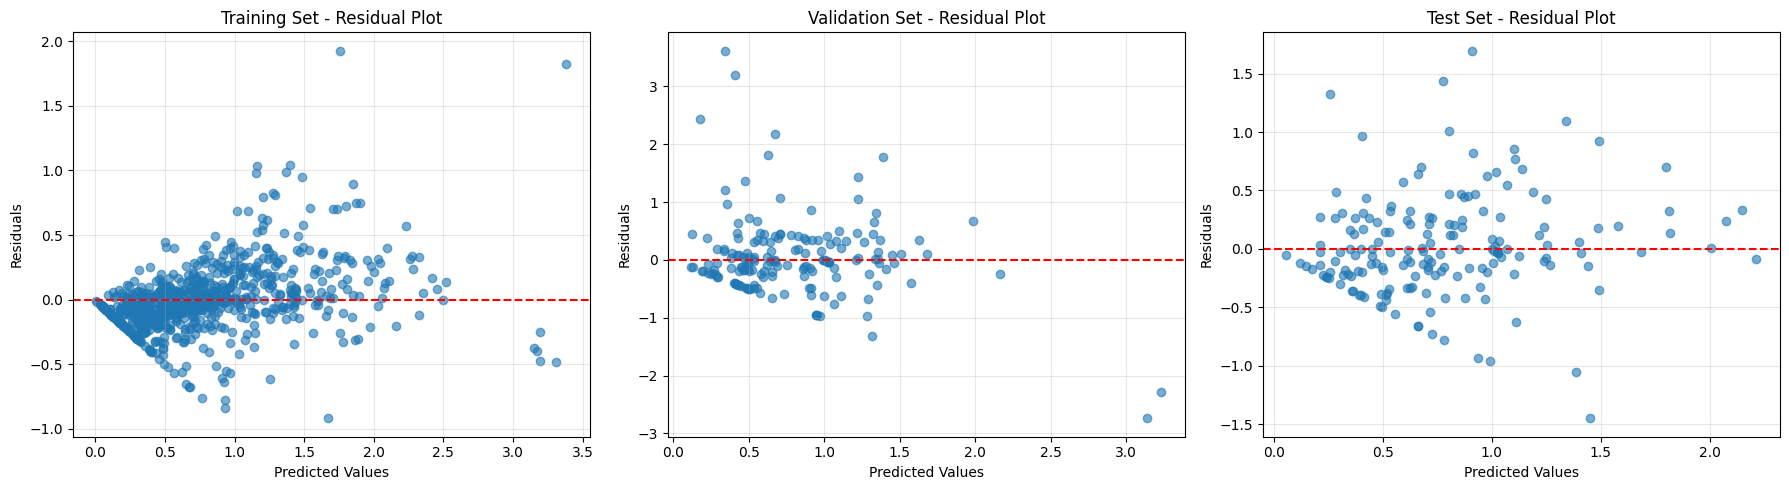

In [61]:
# Regression Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_actual_vs_predicted(y_true, y_pred, ax, title, metrics):
    ax.scatter(y_true, y_pred, alpha=0.6)
    
    # Perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{title} Set\nR² = {metrics["r2"]:.3f}, RMSE = {metrics["rmse"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plot_actual_vs_predicted(y_train, y_train_pred, axes[0], 'Training', train_metrics)
plot_actual_vs_predicted(y_val, y_val_pred, axes[1], 'Validation', val_metrics)
plot_actual_vs_predicted(y_test, y_test_pred, axes[2], 'Test', test_metrics)

plt.tight_layout()
plt.show()

# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_residuals(y_true, y_pred, ax, title):
    residuals = y_true - y_pred
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{title} Set - Residual Plot')
    ax.grid(True, alpha=0.3)

plot_residuals(y_train, y_train_pred, axes[0], 'Training')
plot_residuals(y_val, y_val_pred, axes[1], 'Validation')
plot_residuals(y_test, y_test_pred, axes[2], 'Test')

plt.tight_layout()
plt.show()

Number of features: 61
Number of importance values: 61
FEATURE IMPORTANCE RANKINGS
            feature  importance
          precip_mm    0.056788
           latitude    0.056130
        windchill_c    0.053481
        heatindex_c    0.053222
         Unnamed: 0    0.052458
           gust_kph    0.049562
        feelslike_c    0.047191
            VH_Mean    0.028422
            VV_Mean    0.025998
          longitude    0.025691
              VV_SD    0.020861
            dem_iqr    0.020617
        pressure_mb    0.020246
              cai_1    0.020209
             VH_Min    0.020080
             VV_Min    0.019407
            dem_max    0.019142
             VV_IQR    0.019076
             VH_IQR    0.018272
      soil_moisture    0.017457
             VV_Max    0.017360
        VH_VV_Ratio    0.017064
       cai_wetlands    0.016908
         pct_area_2    0.016653
              VH_SD    0.016590
          area_km_1    0.015408
           dem_mean    0.015219
         dewpoint_c  

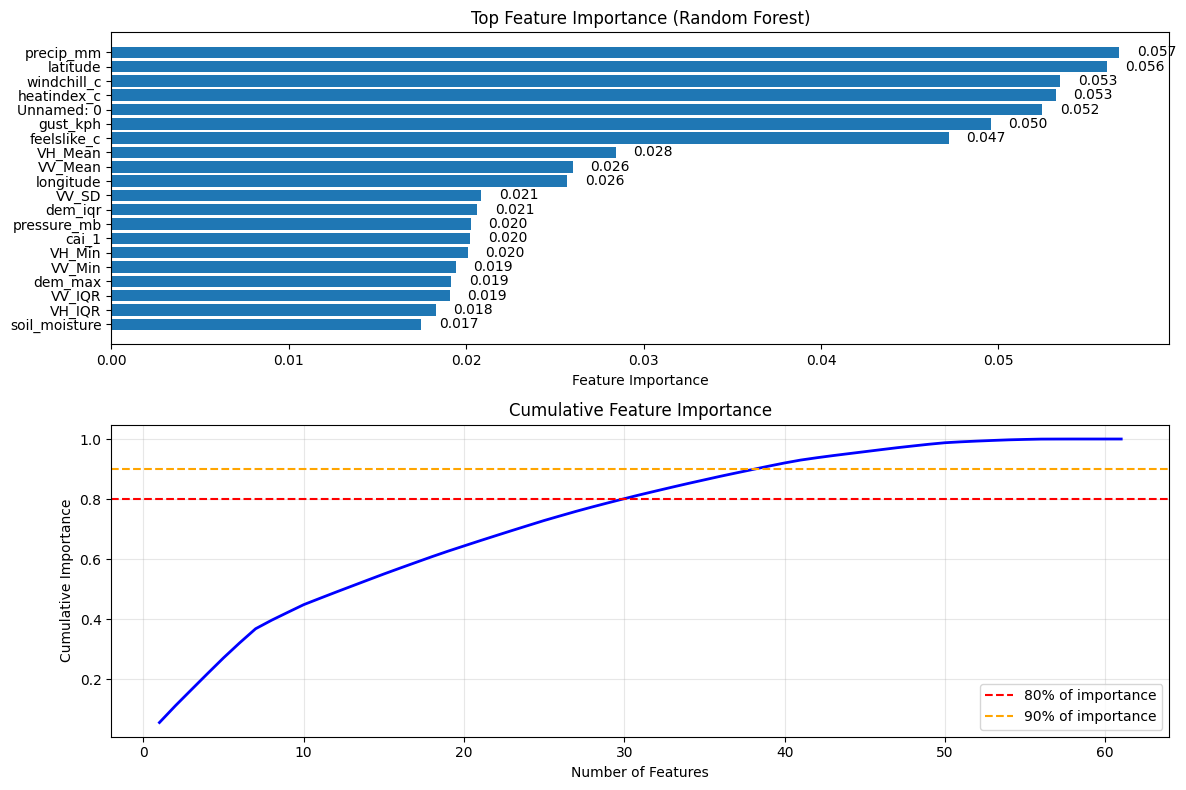


Feature Selection Insights:
Number of features needed for 80% of importance: 30
Number of features needed for 90% of importance: 39
Total number of features: 61

Feature importance saved to: C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\rf_feature_importance.csv


In [63]:
# Feature Importance Analysis
feature_importance = best_rf.feature_importances_

# Get feature names from the processed dataframe (after datetime conversion and numeric selection)
processed_features_df = df_wlabs.drop(['height_above'], axis=1).select_dtypes(include=[np.number])
feature_names = processed_features_df.columns.tolist()

print(f"Number of features: {len(feature_names)}")
print(f"Number of importance values: {len(feature_importance)}")

# Ensure lengths match - if not, create generic names
if len(feature_names) != len(feature_importance):
    print("Warning: Feature names and importance lengths don't match. Using generic names.")
    feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("="*60)
print("FEATURE IMPORTANCE RANKINGS")
print("="*60)
print(importance_df.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

# Horizontal bar plot for top 20 features
top_features = importance_df.head(min(20, len(importance_df)))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance (Random Forest)')
plt.gca().invert_yaxis()

# Add importance values on bars
for i, v in enumerate(top_features['importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')

plt.subplot(2, 1, 2)

# Cumulative importance plot
cumulative_importance = np.cumsum(importance_df['importance'].values)
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% of importance')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% of importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of features needed for 80% and 90% of importance
idx_80 = np.argmax(cumulative_importance >= 0.8) + 1
idx_90 = np.argmax(cumulative_importance >= 0.9) + 1

print(f"\nFeature Selection Insights:")
print(f"Number of features needed for 80% of importance: {idx_80}")
print(f"Number of features needed for 90% of importance: {idx_90}")
print(f"Total number of features: {len(feature_importance)}")

# Save feature importance to CSV
importance_path = r'C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\rf_feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"\nFeature importance saved to: {importance_path}")

In [64]:
# Final Model Summary
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best Random Forest Parameters: {rf_optimized.best_params_}")
print(f"Best Cross-Validation Score (neg_MSE): {rf_optimized.best_score_:.4f}")
print(f"\nFinal Test Set Performance:")
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  MSE: {test_metrics['mse']:.4f}")

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"  Training R²: {train_metrics['r2']:.4f}")
print(f"  Validation R²: {val_metrics['r2']:.4f}")
print(f"  Test R²: {test_metrics['r2']:.4f}")
print(f"  Train-Val R² Gap: {train_metrics['r2'] - val_metrics['r2']:.4f}")
print(f"  Train-Test R² Gap: {train_metrics['r2'] - test_metrics['r2']:.4f}")

if train_metrics['r2'] - test_metrics['r2'] > 0.2:
    print("  WARNING: Potential overfitting detected (>20% R² gap between train and test)")
else:
    print("  Model shows good generalization")

print("\n" + "="*80)

FINAL MODEL SUMMARY
Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
Best Cross-Validation Score (neg_MSE): -0.2750

Final Test Set Performance:
  R² Score: 0.5433
  RMSE: 0.4344
  MAE: 0.3126
  MSE: 0.1887

Overfitting Check:
  Training R²: 0.8611
  Validation R²: 0.0920
  Test R²: 0.5433
  Train-Val R² Gap: 0.7691
  Train-Test R² Gap: 0.3178



In [66]:
# Extract residuals with IDs for all data splits
print("="*60)
print("EXTRACTING RESIDUALS WITH IDs")
print("="*60)

# We need to reconstruct the full dataset with predictions to get residuals with IDs
# First, let's get predictions for the entire dataset
full_X = df_wlabs.drop(['height_above'], axis=1).select_dtypes(include=[np.number]).values
full_y = df_wlabs['height_above'].values
original_ids = df['ID'].values

# Standardize the full dataset using training statistics (same as used for model training)
full_X_norm = (full_X - X_mean) / X_std

# Get predictions for all samples
full_predictions = best_rf.predict(full_X_norm)

# Calculate residuals (actual - predicted)
residuals = full_y - full_predictions

# Create residuals dataframe with IDs
residuals_df = pd.DataFrame({
    'ID': original_ids,
    'Actual_height_above': full_y,
    'Predicted_height_above': full_predictions,
    'Residual': residuals,
    'Absolute_Residual': np.abs(residuals)
})

# Sort by ID for easier analysis
residuals_df = residuals_df.sort_values('ID')

# Display basic statistics
print(f"Total samples: {len(residuals_df)}")
print(f"Mean residual: {residuals_df['Residual'].mean():.4f}")
print(f"Std residual: {residuals_df['Residual'].std():.4f}")
print(f"Mean absolute residual: {residuals_df['Absolute_Residual'].mean():.4f}")

# Show first few rows
print(f"\nFirst 10 rows of residuals:")
print(residuals_df.head(10))

# Save to CSV
output_path = r'C:\Users\alekb\OneDrive - UCB-O365\Research\Flood-height-prediction\data\rf_residuals.csv'
residuals_df.to_csv(output_path, index=False)
print(f"\nResiduals saved to: {output_path}")

# Additional analysis: identify largest residuals
print(f"\nTop 10 largest positive residuals (model under-predicted):")
print(residuals_df.nlargest(10, 'Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

print(f"\nTop 10 largest negative residuals (model over-predicted):")
print(residuals_df.nsmallest(10, 'Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

print(f"\nTop 10 largest absolute residuals:")
print(residuals_df.nlargest(10, 'Absolute_Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

EXTRACTING RESIDUALS WITH IDs
Total samples: 1147
Mean residual: 0.0060
Std residual: 0.3867
Mean absolute residual: 0.2336

First 10 rows of residuals:
         ID  Actual_height_above  Predicted_height_above  Residual  \
966   770.0              0.99568                1.008359 -0.012679   
1020  771.0              0.99568                0.992141  0.003539   
560   772.0              0.99568                1.011331 -0.015651   
1126  773.0              0.99568                0.998422 -0.002742   
102   774.0              0.99568                0.998422 -0.002742   
711   775.0              0.99568                1.008359 -0.012679   
572   776.0              0.99568                1.011331 -0.015651   
468   777.0              0.99568                0.992141  0.003539   
352   778.0              0.99568                0.998247 -0.002567   
1022  779.0              0.99568                0.998247 -0.002567   

      Absolute_Residual  
966            0.012679  
1020           0.003539 